In [1]:
import torch
from torch import nn, optim
from torch.nn import Module as M
from torch.utils.data import Dataset as D
# import torchvision
from torchvision import datasets # for mnist
import torchvision.transforms as transforms
#from transformers import AdamW
#from transformers import get_cosine_schedule_with_warmup
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.optimizer import Optimizer
from efficientnet_pytorch import EfficientNet
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
import numpy as np
import random
import math
import tqdm
#from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2 as AT

import cv2

#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import logging


In [2]:
#device_lib.list_local_device() #tf

In [3]:
VER = 11
MODEL_NAME = 'efficientnet-b0'
NAME = 'plant-pathology-2020-fgvc7_v{}_{}'.format(VER, MODEL_NAME)

# EfficientNet
# Coefficients:   width,depth,res,dropout
#'efficientnet-b0': (1.0, 1.0, 224, 0.2),
#'efficientnet-b1': (1.0, 1.1, 240, 0.2),
#'efficientnet-b2': (1.1, 1.2, 260, 0.3),
#'efficientnet-b3': (1.2, 1.4, 300, 0.3),
#'efficientnet-b4': (1.4, 1.8, 380, 0.4),
#'efficientnet-b5': (1.6, 2.2, 456, 0.4),
#'efficientnet-b6': (1.8, 2.6, 528, 0.5),
#'efficientnet-b7': (2.0, 3.1, 600, 0.5),
#'efficientnet-b8': (2.2, 3.6, 672, 0.5),
#'efficientnet-l2': (4.3, 5.3, 800, 0.5),
IMG_SIZE = 224
DROPOUT = 0.2 # для fc

EPOCH_COUNT = 10
FOLD_COUNT = 5
SEED = 42
CONT_TRAIN = False # more train
RESTORE_TRAIN = False # continue train after server restart
FACTOR = 0.8
PATIENCE = 1

BATCH_SIZE = 64

# Параметры оптимизатора Adam
BETA1 = 0.8
BETA2 = 0.999

#BASE_PATH = '/kaggle/input/plant-pathology-2020-fgvc7'
BASE_PATH = './data'
TRAIN_FILE = os.path.join(BASE_PATH, "train.csv")
TEST_FILE = os.path.join(BASE_PATH, "test.csv")
SUBMISSION_FILE = os.path.join(BASE_PATH, "sample_submission.csv")

USE_GPU = True
device = torch.device('cuda:0' if torch.cuda.is_available() and USE_GPU else 'cpu')

a_tr_loss = []
a_val_loss = []
a_tr_acc = []
a_acc = []

# Скорость обучения
LR = 1e-5


In [4]:
logging.basicConfig(filename=NAME+'.log',
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.INFO)
logging.info('________________________________________________________')
logging.info('Запуск скрипта')
logging.info('________________________________________________________')
logging.info('Колличество фолдов: {}'.format(FOLD_COUNT))
logging.info('Колличество этох в каждом фолне: {}'.format(EPOCH_COUNT))
logging.info('Размер батча: {}'.format(BATCH_SIZE))
logging.info('Cкорость обучения: {}'.format(LR))
logging.info('Adam betas: {{{},{}}}'.format(BETA1, BETA2))
logging.info('Режим продолжения тренировки: {}'.format(CONT_TRAIN))
logging.info('Режим восстановления тренировки: {}'.format(RESTORE_TRAIN))
logging.info('________________________________________________________')


In [5]:
train_df = pd.read_csv(TRAIN_FILE)
#train_df.head()

In [6]:
test_df = pd.read_csv(TEST_FILE)
#test_df.head()

In [7]:
submission_df = pd.read_csv(SUBMISSION_FILE)
submission_df.iloc[:, 1:] = 0

#submission_df.head()

In [8]:
class digitDataset(D):
    def __init__(self, df, transform=None): #, labels=None
        if 'healthy' in df: # ['healthy','multiple_diseases','rust','scab']
            self.images_id = df['image_id'].values
            self.labels = df.drop(axis=1, columns='image_id').values
            self.labels = self.labels[:, 1] + self.labels[:, 2] * 2 + self.labels[:, 3] * 3
        else:
            self.images_id = df['image_id'].values
            self.labels = np.zeros(len(df))
        
        self.transform = transform
            
    def __len__(self):
        return len(self.images_id)
    
    def __getitem__(self, idx):
        image_src = BASE_PATH + '/images/' + self.images_id[idx] + '.jpg'
        image = cv2.imread(image_src) #, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.labels[idx]
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        image = np.multiply(image, 1/255)
        image = torch.from_numpy(np.array(image, dtype=np.float32))

        return image, labels


In [9]:
def imshow(imgs, lbls, epoh='', batch=''):
    x = int(math.sqrt(len(imgs)))+1
    y = x + 1
    imgs = np.multiply(imgs, 255)
    fig = plt.figure(figsize=(15, 16))
    for i, img in enumerate(imgs):
        img = np.rollaxis(img.numpy(), 0, 3)
        img = np.uint8(img)
        ax = fig.add_subplot(x, y, i+1)
        ax.set_title(str(lbls.numpy()[i]))
        ax.imshow(img, cmap = cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [23]:
def load_model(criterion=''):
    global model, a_tr_loss, a_val_loss, a_acc, c_i_fold, c_epoch, lr
    if criterion != '':
        criterion = '_'+criterion

    logging.info('Восстановление весов модели')
    checkpoint = torch.load(NAME+'{}_model.pt'.format(criterion), map_location=device) #'cpu'

    if VER != checkpoint['ver']:
        raise RuntimeError("Incorrect model version.")

    model.load_state_dict(checkpoint['model_state_dict'])

    a_tr_loss = checkpoint['tr_loss']
    a_val_loss = checkpoint['val_loss']
    a_tr_acc = checkpoint['tr_acc']
    a_acc = checkpoint['acc']
    c_i_fold = checkpoint['i_fold']
    c_epoch = checkpoint['epoch']
    lr = checkpoint['lr']

    logging.info('Восстановление lr: {}'.format(lr))
    logging.info('Восстановление c_i_fold: {}'.format(c_i_fold))
    logging.info('Восстановление c_epoch: {}'.format(c_epoch))


In [11]:
class KScheduler(object):
    '''
        Класс KScheduler создает нелинейное lr
    '''
    def __init__(self, optimizer, epoch=0): # , lr): # , last_epoch=-1):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        #if last_epoch == -1:
        #    for group in optimizer.param_groups:
        #        group.setdefault('initial_lr', group['lr'])
        #else:
        #    for i, group in enumerate(optimizer.param_groups):
        #        if 'initial_lr' not in group:
        #            raise KeyError("param 'initial_lr' is not specified "
        #                           "in param_groups[{}] when resuming an optimizer".format(i))
        #self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.base_lrs = [p['lr'] for p in optimizer.param_groups]
        lr = self.base_lrs[0]
        #self.last_epoch = last_epoch
        
        self.LR_START = lr    # 0.00001
        self.LR_MAX = lr * 10 # 0.0001 * 1
        self.LR_MIN = lr / 2  # 0.00001
        self.LR_RAMPUP_EPOCHS = 10
        self.LR_SUSTAIN_EPOCHS = 3
        self.LR_EXP_DECAY = .8
        
        self.last_epoch = epoch
        #self.lr = self.base_lrs[0]

        #self.optimizer.step = with_counter(self.optimizer.step)
        #self.optimizer._step_count = 0
        self._step_count = 0

        #self.step()

    #def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        #raise NotImplementedError

    def get_last_lr(self):
        """ Return last computed learning rate by current scheduler.
        """
        return self._last_lr

    def step(self, epoch=None):

        self._step_count += 1
        
        if epoch is None:
            self.last_epoch += 1
        else:
            self.last_epoch = epoch
        
        
        #values = self.get_lr()
        lr = self._lr(self.last_epoch)

        print('LR is set to {}'.format(lr))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer
    
    def _lr(self, epoch):
        if epoch < self.LR_RAMPUP_EPOCHS: #if epoch is lower then 15
            lr = (self.LR_MAX - self.LR_START) / self.LR_RAMPUP_EPOCHS * epoch + self.LR_START
        elif epoch < self.LR_RAMPUP_EPOCHS + self.LR_SUSTAIN_EPOCHS:
            lr = self.LR_MAX
        else:
            lr = (self.LR_MAX - self.LR_MIN) * self.LR_EXP_DECAY**(epoch - self.LR_RAMPUP_EPOCHS - self.LR_SUSTAIN_EPOCHS) + self.LR_MIN
        return lr

    def show(self, epochs):

        #Смотрим что у нас получилось
        y = [self._lr(x) for x in range(epochs)]
        plt.plot(range(epochs), y)
        print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


Loaded pretrained weights for efficientnet-b0
Learning rate schedule: 1e-05 to 0.0001 to 5.03e-06


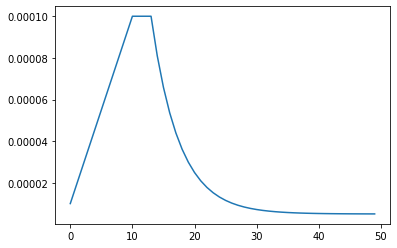

In [12]:
logging.info('Создание модели')

class ppModel(M):
    def __init__(self, MODEL_NAME, DROPOUT):
        super(ppModel, self).__init__()

        self.efn = EfficientNet.from_pretrained(MODEL_NAME)
        self.fc = nn.Sequential(nn.ReLU(),
                                nn.Dropout(p=DROPOUT),
                                nn.Linear(1000, 4, bias=False),
        )

    def forward(self, x):
        x = self.efn(x)
        x = self.fc(x)
        return x

model = ppModel(MODEL_NAME, DROPOUT)

optimizer = optim.Adam(model.parameters(), lr=LR, betas=(BETA1, BETA2))
#optimizer = optim.AdamW(model.parameters(), lr = 8e-4, weight_decay = 1e-3)

scheduler = KScheduler(optimizer)
#scheduler = lr_scheduler.LambdaLR(optimizer, lrfn)
#scheduler = lr_scheduler.MultiplicativeLR(optimizer, lrfn)
scheduler.show(FOLD_COUNT * EPOCH_COUNT)

if CONT_TRAIN:
    logging.info('Запущен режим продолжения тренировки')

if RESTORE_TRAIN:
    logging.info('Запущен режим восстановления процесса тренировки')

if CONT_TRAIN or RESTORE_TRAIN:
    load_model()

criterion = nn.CrossEntropyLoss()

model = model.to(device)

# summary(model, (3, IMG_SIZE, IMG_SIZE))
# raise RuntimeError("Break")


In [13]:
def train(model, train_loader, criterion, optimizer, noise=True, show=False, show_first=False):
    model.train()
    tr_loss = 0
    correct = 0
    count = 0
    
    for step, batch in enumerate(tqdm.tqdm(train_loader)):
            
        images = batch[0]
        labels = batch[1]
        
        count += len(images)
        
        # добавляем шума
        if noise:
            images = images + torch.normal(0, 0.0001, size=images.size())
        
        if show:
            imshow(images, labels)
        if show_first and step == 0:
            imshow(images, labels)
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()

        tr_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        
    return tr_loss / len(train_loader), correct / count

In [14]:
# torch.normal(0, 0.0001)
#torch.normal(mean=torch.arange(1., 9.), std=torch.arange(1, 0, -0.1))
#torch.normal(0, 0.0001, size=(1, 4))
#images.size()

In [15]:
def valid(model, valid_loader, criterion, optimizer):
    model.eval()
    val_loss = 0
    correct = 0
    count = 0

    for step, batch in enumerate(tqdm.tqdm(valid_loader)):

            images = batch[0]
            labels = batch[1]

            count += len(images)

            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                    
    return val_loss / len(valid_loader), correct / count

In [16]:
def test(model, test_loader, criterion, optimizer):
    model.eval()
    test_preds = None
    
    for step, batch in enumerate(tqdm.tqdm(test_loader)):

        images = batch[0]
        images = images.to(device) #, dtype=torch.float)

        with torch.no_grad():
            outputs = model(images)

            
            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
    return test_preds


In [17]:
train_transform = A.Compose([
    ###A.CenterCrop(height=1365, width=1365, always_apply=True),
    A.RandomCrop(height=1000, width=1000, always_apply=True),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=90.0, p=0.7),
    A.OneOf([A.IAAEmboss(p=1),
             A.IAASharpen(p=1),
             A.Blur(p=1)], p=0.5),
    A.IAAPiecewiseAffine(p=0.5),
    #A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
    AT(always_apply=True),
])

test_transform = A.Compose([
    A.CenterCrop(height=1365, width=1365, always_apply=True),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    #A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
    AT(always_apply=True),
])

In [18]:
def show_history():
    plt.plot(range(0, len(a_tr_loss)), a_tr_loss, color='green', label='Training loss')
    plt.plot(range(0, len(a_val_loss)), a_val_loss, color='red', label='Validation loss')
    plt.legend()
    plt.figure()

    plt.plot(range(0, len(a_tr_acc)), a_tr_acc, color='green', label='Training acc')
    plt.plot(range(0, len(a_acc)), a_acc, color='red', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.show()

In [19]:
for name, child in model.named_children():
    if name != '_fc' and name != '_swish':
        print("name1: -", name)
#        child.requires_grad = False
        for name2, params in child.named_parameters():
            print("name2: -", name2)
#            params.requires_grad = False
    else:
        print("name1: +", name)
#        child.requires_grad = True
        for name2, params in child.named_parameters():
            print("name2: +", name2)
#            params.requires_grad = True


name1: - efn
name2: - _conv_stem.weight
name2: - _bn0.weight
name2: - _bn0.bias
name2: - _blocks.0._depthwise_conv.weight
name2: - _blocks.0._bn1.weight
name2: - _blocks.0._bn1.bias
name2: - _blocks.0._se_reduce.weight
name2: - _blocks.0._se_reduce.bias
name2: - _blocks.0._se_expand.weight
name2: - _blocks.0._se_expand.bias
name2: - _blocks.0._project_conv.weight
name2: - _blocks.0._bn2.weight
name2: - _blocks.0._bn2.bias
name2: - _blocks.1._expand_conv.weight
name2: - _blocks.1._bn0.weight
name2: - _blocks.1._bn0.bias
name2: - _blocks.1._depthwise_conv.weight
name2: - _blocks.1._bn1.weight
name2: - _blocks.1._bn1.bias
name2: - _blocks.1._se_reduce.weight
name2: - _blocks.1._se_reduce.bias
name2: - _blocks.1._se_expand.weight
name2: - _blocks.1._se_expand.bias
name2: - _blocks.1._project_conv.weight
name2: - _blocks.1._bn2.weight
name2: - _blocks.1._bn2.bias
name2: - _blocks.2._expand_conv.weight
name2: - _blocks.2._bn0.weight
name2: - _blocks.2._bn0.bias
name2: - _blocks.2._depthwise_

In [20]:
logging.info('Запуск тренировки')

folds = StratifiedKFold(n_splits=FOLD_COUNT, shuffle=True, random_state=SEED)

if CONT_TRAIN or RESTORE_TRAIN:
    min_val_loss = a_val_loss[-1]
    max_val_acc = a_acc_[-1]
    logging.info('Восстановление min_val_loss:{}'.format(min_val_loss))
    print('Восстановление min_val_loss:{}'.format(min_val_loss))
else:
    min_val_loss = math.inf
    max_val_acc = 0


train_y = train_df.drop(axis=1, columns='image_id').values
train_y = train_y[:, 1] + train_y[:, 2] * 2 + train_y[:, 3] * 3
for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_y)):
    train_data = train_df.loc[train_idx]
    valid_data = train_df.loc[valid_idx]

    trainset = digitDataset(train_data, transform=train_transform)
    validset = digitDataset(valid_data, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = BATCH_SIZE,
                                           drop_last=True,
                                           shuffle = True)
    valid_loader = torch.utils.data.DataLoader(validset, 
                                          batch_size = BATCH_SIZE, 
                                          shuffle = False)
    
    for epoch in range(EPOCH_COUNT):
        if RESTORE_TRAIN:
            if i_fold < c_i_fold or (i_fold == c_i_fold and epoch <= c_epoch):
                logging.info('Пропускаем i_fold:{} epoch:{}'.format(i_fold+1, epoch+1))
                print('Пропускаем i_fold:{} epoch:{}'.format(i_fold+1, epoch+1))
                continue
        else:
            #scheduler - перед тренировкой задаем lr зависящий от "эпохи"
            #optimizer = exp_lr_scheduler(optimizer, i_fold*EPOCH_COUNT+epoch)

            logging.info('({}/{}) Запуск эпохи тренировки'.format(i_fold+1, epoch+1))
            tr_loss, tr_acc = train(model, train_loader, criterion, optimizer, show_first=False)
            logging.info('({}/{}) Запуск эпохи валидации'.format(i_fold+1, epoch+1))
            val_loss, acc = valid(model, valid_loader, criterion, optimizer)

            lrs = [p['lr'] for p in optimizer.param_groups]

            logging.info('({}/{}) tr_loss:{:.4f} val_loss:{:.4f}, acc:{:.4f}, lr:{}'.format(i_fold+1, epoch+1, tr_loss, val_loss, acc, lrs[0]))
            print('({}/{}) tr_loss:{:.4f} val_loss:{:.4f}, acc:{:.4f}, lr:{}'.format(i_fold+1, epoch+1, tr_loss, val_loss, acc, lrs[0]))

            a_tr_loss.append(tr_loss)
            a_val_loss.append(val_loss)
            a_tr_acc.append(tr_acc)
            a_acc.append(acc)

            if min_val_loss > val_loss:
                logging.info('({}/{}) Получен минимальный loss: {} > {}) '.format(i_fold+1, epoch+1, min_val_loss, val_loss))
                print ('({}/{}) Получен минимальный loss: {} > {}) '.format(i_fold+1, epoch+1, min_val_loss, val_loss))
                min_val_loss = val_loss
                logging.info('Запись модели: {}_loss_model.pt'.format(NAME))
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'i_fold': i_fold,
                            'epoch': epoch,
                            'tr_loss': a_tr_loss,
                            'val_loss': a_val_loss,
                            'tr_acc': a_tr_acc,
                            'acc': a_acc,
                            'lr': lrs[0],
                            'ver': VER
                        },
                        '{}_loss_model.pt'.format(NAME),
                       )

            if max_val_acc < acc:
                logging.info('({}/{}) Получен максимальный acc: {} < {}) '.format(i_fold+1, epoch+1, max_val_acc, acc))
                print ('({}/{}) Получен максимальный acc: {} < {}) '.format(i_fold+1, epoch+1, max_val_acc, acc))
                max_val_acc = acc
                logging.info('Запись модели: {}_acc_model.pt'.format(NAME))
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'i_fold': i_fold,
                            'epoch': epoch,
                            'tr_loss': a_tr_loss,
                            'val_loss': a_val_loss,
                            'tr_acc': a_tr_acc,
                            'acc': a_acc,
                            'lr': lrs[0],
                            'ver': VER
                        },
                        '{}_acc_model.pt'.format(NAME),
                       )
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'i_fold': i_fold,
                        'epoch': epoch,
                        'tr_loss': a_tr_loss,
                        'val_loss': a_val_loss,
                        'tr_acc': a_tr_acc,
                        'acc': a_acc,
                        'lr': lrs[0],
                        'ver': VER
                    },
                    '{}_model.pt'.format(NAME),
            )

        scheduler.step()


100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


(1/1) tr_loss:1.5310 val_loss:1.6972, acc:0.1370, lr:1e-05
(1/1) Получен минимальный loss: inf > 1.6971976558367412) 
(1/1) Получен максимальный acc: 0 < 0.136986301369863) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.9e-05


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


(1/2) tr_loss:1.3798 val_loss:1.4549, acc:0.2247, lr:1.9e-05
(1/2) Получен минимальный loss: 1.6971976558367412 > 1.4549285769462585) 
(1/2) Получен максимальный acc: 0.136986301369863 < 0.22465753424657534) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 2.8000000000000003e-05


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(1/3) tr_loss:1.2210 val_loss:1.1990, acc:0.5014, lr:2.8000000000000003e-05
(1/3) Получен минимальный loss: 1.4549285769462585 > 1.1989817023277283) 
(1/3) Получен максимальный acc: 0.22465753424657534 < 0.5013698630136987) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 3.7e-05


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(1/4) tr_loss:1.0581 val_loss:0.9562, acc:0.6740, lr:3.7e-05
(1/4) Получен минимальный loss: 1.1989817023277283 > 0.9562391142050425) 
(1/4) Получен максимальный acc: 0.5013698630136987 < 0.673972602739726) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 4.6e-05


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(1/5) tr_loss:0.8823 val_loss:0.7716, acc:0.7589, lr:4.6e-05
(1/5) Получен минимальный loss: 0.9562391142050425 > 0.771559864282608) 
(1/5) Получен максимальный acc: 0.673972602739726 < 0.7589041095890411) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.5e-05


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(1/6) tr_loss:0.7056 val_loss:0.6475, acc:0.8082, lr:5.5e-05
(1/6) Получен минимальный loss: 0.771559864282608 > 0.647494817773501) 
(1/6) Получен максимальный acc: 0.7589041095890411 < 0.8082191780821918) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 6.4e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(1/7) tr_loss:0.5476 val_loss:0.6151, acc:0.8110, lr:6.4e-05
(1/7) Получен минимальный loss: 0.647494817773501 > 0.6151108741760254) 
(1/7) Получен максимальный acc: 0.8082191780821918 < 0.810958904109589) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 7.3e-05


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


(1/8) tr_loss:0.4702 val_loss:0.5445, acc:0.8384, lr:7.3e-05
(1/8) Получен минимальный loss: 0.6151108741760254 > 0.5444727142651876) 
(1/8) Получен максимальный acc: 0.810958904109589 < 0.8383561643835616) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 8.2e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(1/9) tr_loss:0.4140 val_loss:0.4614, acc:0.8575, lr:8.2e-05
(1/9) Получен минимальный loss: 0.5444727142651876 > 0.46143631140391034) 
(1/9) Получен максимальный acc: 0.8383561643835616 < 0.8575342465753425) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 9.1e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(1/10) tr_loss:0.3728 val_loss:0.3326, acc:0.8877, lr:9.1e-05
(1/10) Получен минимальный loss: 0.46143631140391034 > 0.33261087785164517) 
(1/10) Получен максимальный acc: 0.8575342465753425 < 0.8876712328767123) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 0.0001


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(2/1) tr_loss:0.3394 val_loss:0.2302, acc:0.9176, lr:0.0001
(2/1) Получен минимальный loss: 0.33261087785164517 > 0.23019455869992575) 
(2/1) Получен максимальный acc: 0.8876712328767123 < 0.9175824175824175) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 0.0001


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(2/2) tr_loss:0.3068 val_loss:0.2081, acc:0.9286, lr:0.0001
(2/2) Получен минимальный loss: 0.23019455869992575 > 0.20806262269616127) 
(2/2) Получен максимальный acc: 0.9175824175824175 < 0.9285714285714286) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 0.0001


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(2/3) tr_loss:0.2699 val_loss:0.1717, acc:0.9396, lr:0.0001
(2/3) Получен минимальный loss: 0.20806262269616127 > 0.17172934984167418) 
(2/3) Получен максимальный acc: 0.9285714285714286 < 0.9395604395604396) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 0.0001


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(2/4) tr_loss:0.2870 val_loss:0.1766, acc:0.9451, lr:0.0001
(2/4) Получен максимальный acc: 0.9395604395604396 < 0.945054945054945) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 8.1e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(2/5) tr_loss:0.2645 val_loss:0.1759, acc:0.9451, lr:8.1e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 6.580000000000001e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(2/6) tr_loss:0.2452 val_loss:0.1758, acc:0.9505, lr:6.580000000000001e-05
(2/6) Получен максимальный acc: 0.945054945054945 < 0.9505494505494505) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.3640000000000015e-05


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(2/7) tr_loss:0.2173 val_loss:0.1656, acc:0.9505, lr:5.3640000000000015e-05
(2/7) Получен минимальный loss: 0.17172934984167418 > 0.16557214905818304) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 4.391200000000001e-05


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(2/8) tr_loss:0.2440 val_loss:0.1740, acc:0.9478, lr:4.391200000000001e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 3.612960000000001e-05


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(2/9) tr_loss:0.2514 val_loss:0.1763, acc:0.9533, lr:3.612960000000001e-05
(2/9) Получен максимальный acc: 0.9505494505494505 < 0.9532967032967034) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 2.9903680000000012e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(2/10) tr_loss:0.2272 val_loss:0.1769, acc:0.9505, lr:2.9903680000000012e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 2.492294400000001e-05


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


(3/1) tr_loss:0.2595 val_loss:0.1417, acc:0.9478, lr:2.492294400000001e-05
(3/1) Получен минимальный loss: 0.16557214905818304 > 0.1416640281677246) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 2.093835520000001e-05


100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


(3/2) tr_loss:0.2638 val_loss:0.1391, acc:0.9505, lr:2.093835520000001e-05
(3/2) Получен минимальный loss: 0.1416640281677246 > 0.13908939560254416) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.7750684160000006e-05


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


(3/3) tr_loss:0.2283 val_loss:0.1391, acc:0.9451, lr:1.7750684160000006e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.5200547328000007e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(3/4) tr_loss:0.2383 val_loss:0.1403, acc:0.9451, lr:1.5200547328000007e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.3160437862400007e-05


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(3/5) tr_loss:0.2347 val_loss:0.1396, acc:0.9505, lr:1.3160437862400007e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.1528350289920004e-05


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


(3/6) tr_loss:0.2339 val_loss:0.1399, acc:0.9533, lr:1.1528350289920004e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 1.0222680231936003e-05


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


(3/7) tr_loss:0.2218 val_loss:0.1413, acc:0.9505, lr:1.0222680231936003e-05


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 9.178144185548804e-06


100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


(3/8) tr_loss:0.2057 val_loss:0.1428, acc:0.9505, lr:9.178144185548804e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 8.342515348439044e-06


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


(3/9) tr_loss:0.2413 val_loss:0.1442, acc:0.9505, lr:8.342515348439044e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 7.674012278751236e-06


100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


(3/10) tr_loss:0.2173 val_loss:0.1443, acc:0.9505, lr:7.674012278751236e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 7.139209823000988e-06


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(4/1) tr_loss:0.2120 val_loss:0.0851, acc:0.9588, lr:7.139209823000988e-06
(4/1) Получен минимальный loss: 0.13908939560254416 > 0.08511879295110703) 
(4/1) Получен максимальный acc: 0.9532967032967034 < 0.9587912087912088) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 6.7113678584007905e-06


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


(4/2) tr_loss:0.2276 val_loss:0.0854, acc:0.9588, lr:6.7113678584007905e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 6.369094286720632e-06


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(4/3) tr_loss:0.2404 val_loss:0.0861, acc:0.9588, lr:6.369094286720632e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 6.095275429376507e-06


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


(4/4) tr_loss:0.2370 val_loss:0.0856, acc:0.9588, lr:6.095275429376507e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.876220343501205e-06


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(4/5) tr_loss:0.2316 val_loss:0.0861, acc:0.9588, lr:5.876220343501205e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.700976274800964e-06


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


(4/6) tr_loss:0.2414 val_loss:0.0866, acc:0.9588, lr:5.700976274800964e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.560781019840772e-06


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


(4/7) tr_loss:0.2258 val_loss:0.0866, acc:0.9588, lr:5.560781019840772e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.448624815872617e-06


100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


(4/8) tr_loss:0.2217 val_loss:0.0860, acc:0.9588, lr:5.448624815872617e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.358899852698094e-06


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


(4/9) tr_loss:0.2068 val_loss:0.0855, acc:0.9588, lr:5.358899852698094e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.287119882158475e-06


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


(4/10) tr_loss:0.2249 val_loss:0.0852, acc:0.9560, lr:5.287119882158475e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.2296959057267805e-06


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


(5/1) tr_loss:0.2287 val_loss:0.0869, acc:0.9753, lr:5.2296959057267805e-06
(5/1) Получен максимальный acc: 0.9587912087912088 < 0.9752747252747253) 


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.183756724581424e-06


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


(5/2) tr_loss:0.2205 val_loss:0.0865, acc:0.9753, lr:5.183756724581424e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.1470053796651396e-06


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


(5/3) tr_loss:0.2085 val_loss:0.0878, acc:0.9725, lr:5.1470053796651396e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.117604303732112e-06


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


(5/4) tr_loss:0.2221 val_loss:0.0884, acc:0.9753, lr:5.117604303732112e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.09408344298569e-06


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


(5/5) tr_loss:0.2248 val_loss:0.0878, acc:0.9753, lr:5.09408344298569e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.075266754388552e-06


100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


(5/6) tr_loss:0.2155 val_loss:0.0886, acc:0.9753, lr:5.075266754388552e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.060213403510841e-06


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


(5/7) tr_loss:0.2102 val_loss:0.0885, acc:0.9725, lr:5.060213403510841e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.048170722808673e-06


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


(5/8) tr_loss:0.2307 val_loss:0.0885, acc:0.9725, lr:5.048170722808673e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.0385365782469385e-06


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


(5/9) tr_loss:0.2160 val_loss:0.0901, acc:0.9725, lr:5.0385365782469385e-06


  0%|          | 0/22 [00:00<?, ?it/s]

LR is set to 5.030829262597551e-06


100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


(5/10) tr_loss:0.2173 val_loss:0.0892, acc:0.9753, lr:5.030829262597551e-06
LR is set to 5.024663410078041e-06


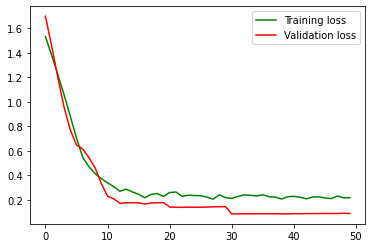

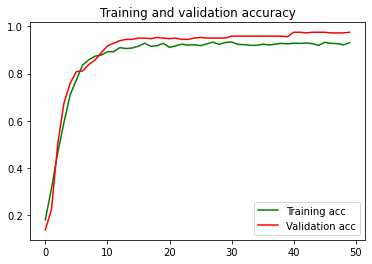

<Figure size 432x288 with 0 Axes>

In [21]:
show_history()

In [26]:
def preds(criterion=''):
    if criterion == '':
        t = ''
    else:
        t = '_'+criterion
        
    logging.info('Запуск предсказания: {}'.format(criterion))

    load_model(criterion)

    testset = digitDataset(test_df, transform=test_transform)

    test_loader = torch.utils.data.DataLoader(testset, 
                                              batch_size = BATCH_SIZE, 
                                              shuffle = False)

    test_preds = test(model, test_loader, criterion, optimizer)

    logging.info('Запись предсказаной в файл {}{}_submission.csv'.format(NAME, t))
    submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
    submission_df.to_csv('{}{}_submission.csv'.format(NAME, t), index=False)

preds('loss')
preds('acc')
preds()

100%|██████████| 29/29 [01:21<00:00,  2.81s/it]


In [ ]:
logging.info('Завершение скрипта')

In [ ]:
show_history()

In [ ]:
len(a_acc)